In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,roc_curve,auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
top_50_path = "/content/drive/My Drive/facescrub_top_50_classes"




train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,   # تحريك الصورة أفقياً
    height_shift_range=0.2,  # تحريك الصورة عمودياً
    shear_range=0.2,         # تشويه القص
    brightness_range=[0.8, 1.2],  # تغيير سطوع الصورة
    horizontal_flip=True,    # انعكاس أفقي للصور
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [ ]:
train_generator_resnet = train_datagen.flow_from_directory(
    top_50_path,
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator_resnet = val_datagen.flow_from_directory(
    top_50_path,
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 4615 images belonging to 50 classes.
Found 1129 images belonging to 50 classes.


In [ ]:
## Define a residual block
def residual_block(x, filters, stride=1, use_projection=False):
    """
    A single residual block.

    Args:
        x: Input tensor
        filters: Number of filters in convolutional layers
        stride: Stride for the first convolution
        use_projection: Whether to use a projection shortcut

    Returns:
        Output tensor after applying the residual block
    """
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut connection
    if use_projection or stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

In [ ]:
# Build ResNet model
def build_resnet(input_shape, num_classes, depth=[2, 2, 2, 2]):
    """
    Build ResNet model.

    Args:
        input_shape: Shape of the input images (e.g., (224, 224, 3))
        num_classes: Number of output classes
        depth: Number of residual blocks in each stage

    Returns:
        ResNet model
    """
    inputs = layers.Input(shape=input_shape)
    # Initial convolution and max-pooling
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(x)

    # Residual blocks for each stage
    filter_sizes = [64, 128, 256, 512]
    for i, num_blocks in enumerate(depth):
        for j in range(num_blocks):
            stride = 2 if j == 0 and i > 0 else 1
            use_projection = (j == 0)
            x = residual_block(x, filters=filter_sizes[i], stride=stride, use_projection=use_projection)

    # Global average pooling and dense layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [ ]:
# تعريف النموذج
# Define model parameters
input_shape = (128, 128, 3)  # Example input size for ResNet
num_classes = 50             # Number of output classes

# Build the model
model = build_resnet(input_shape, num_classes)
# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# file_path = "/content/drive/My Drive/resnet_checkpoint.keras"

# # إنشاء الملف بامتداد .keras
# with open(file_path, "w") as file:
#     file.write("")  # ملف فارغ

# print(f"File created at: {file_path}")


# from tensorflow.keras.callbacks import ModelCheckpoint

# # تعريف مسار الحفظ
# checkpoint_path = "/content/drive/My Drive/resnet_checkpoint.keras"

# # إنشاء كائن ModelCheckpoint
# checkpoint = ModelCheckpoint(
#     filepath=checkpoint_path,  # مسار الحفظ
#     monitor='val_loss',       # معيار المراقبة
#     save_best_only=True,      # حفظ النموذج فقط إذا كان أفضل من السابق
#     verbose=1                 # عرض رسائل عند الحفظ
# )

In [ ]:
history = model.fit(
    train_generator_resnet,
    steps_per_epoch=train_generator_resnet.samples // train_generator_resnet.batch_size,
    epochs=10,
    # callbacks=[checkpoint]
    validation_data=val_generator_resnet,  # إضافة بيانات التحقق
    validation_steps=val_generator_resnet.samples // val_generator_resnet.batch_size  # تحديد خطوات التحقق
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 907s 13s/step - accuracy: 0.1872 - loss: 3.0153 - val_accuracy: 0.0349 - val_loss: 8.2329
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2656 - loss: 3.0319 - val_accuracy: 0.0244 - val_loss: 7.8358
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 677s 9s/step - accuracy: 0.2622 - loss: 2.6746 - val_accuracy: 0.0175 - val_loss: 23.4004
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3438 - loss: 2.4740 - val_accuracy: 0.0244 - val_loss: 21.7032
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 669s 9s/step - accuracy: 0.2766 - loss: 2.5394 - val_accuracy: 0.2279 - val_loss: 3.6319
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4062 - loss: 2.0773 - val_accuracy: 0.2439 - val_loss: 3.4520
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 672s 9s/step - accuracy: 0.3388 - loss: 2.2446 - val_accuracy: 0.2279 - val_loss: 3.3649
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 513ms/step - accuracy: 0.4531 - loss: 2.0947 - val_accuracy: 0.3

In [ ]:
oss, accuracy = model.evaluate(val_generator_resnet)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.0687 - loss: 4.7085
Validation Accuracy: 7.62%


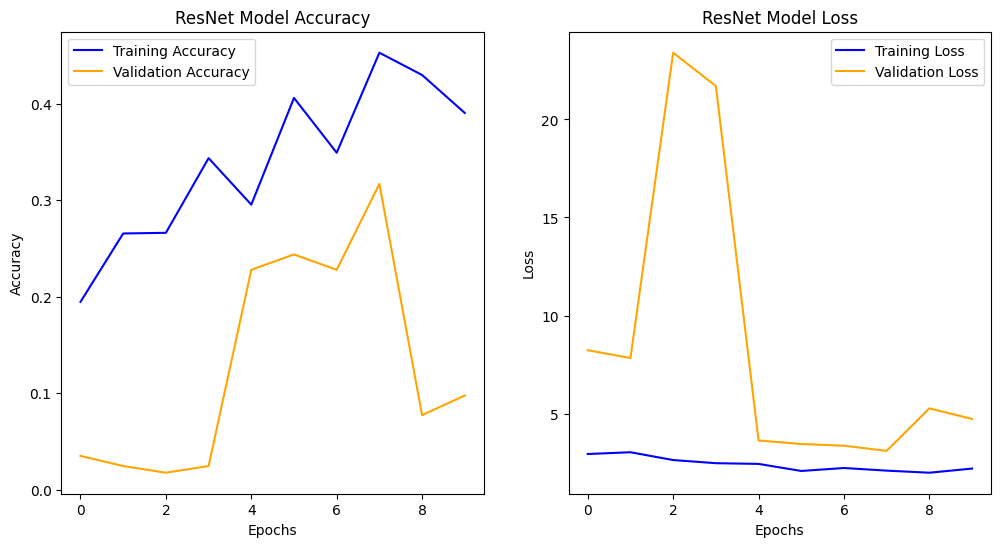

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('ResNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
all_imgs = []
all_labels = []

for i in range(len(val_generator_resnet)):
    imgs, labels = next(val_generator_resnet)
    all_imgs.append(imgs)
    all_labels.append(labels)

# تحويل القوائم إلى مصفوفات
all_imgs = np.vstack(all_imgs)
all_labels = np.vstack(all_labels)

# التنبؤ بكل الصور دفعة واحدة
y_pred = model.predict(all_imgs)

# تحويل التنبؤات إلى الفئات
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(all_labels, axis=1)

# # عرض النتائج
# print("Predicted Classes:", y_pred_classes[:10])
# print("True Classes:", y_true_classes[:10])

36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 972ms/step


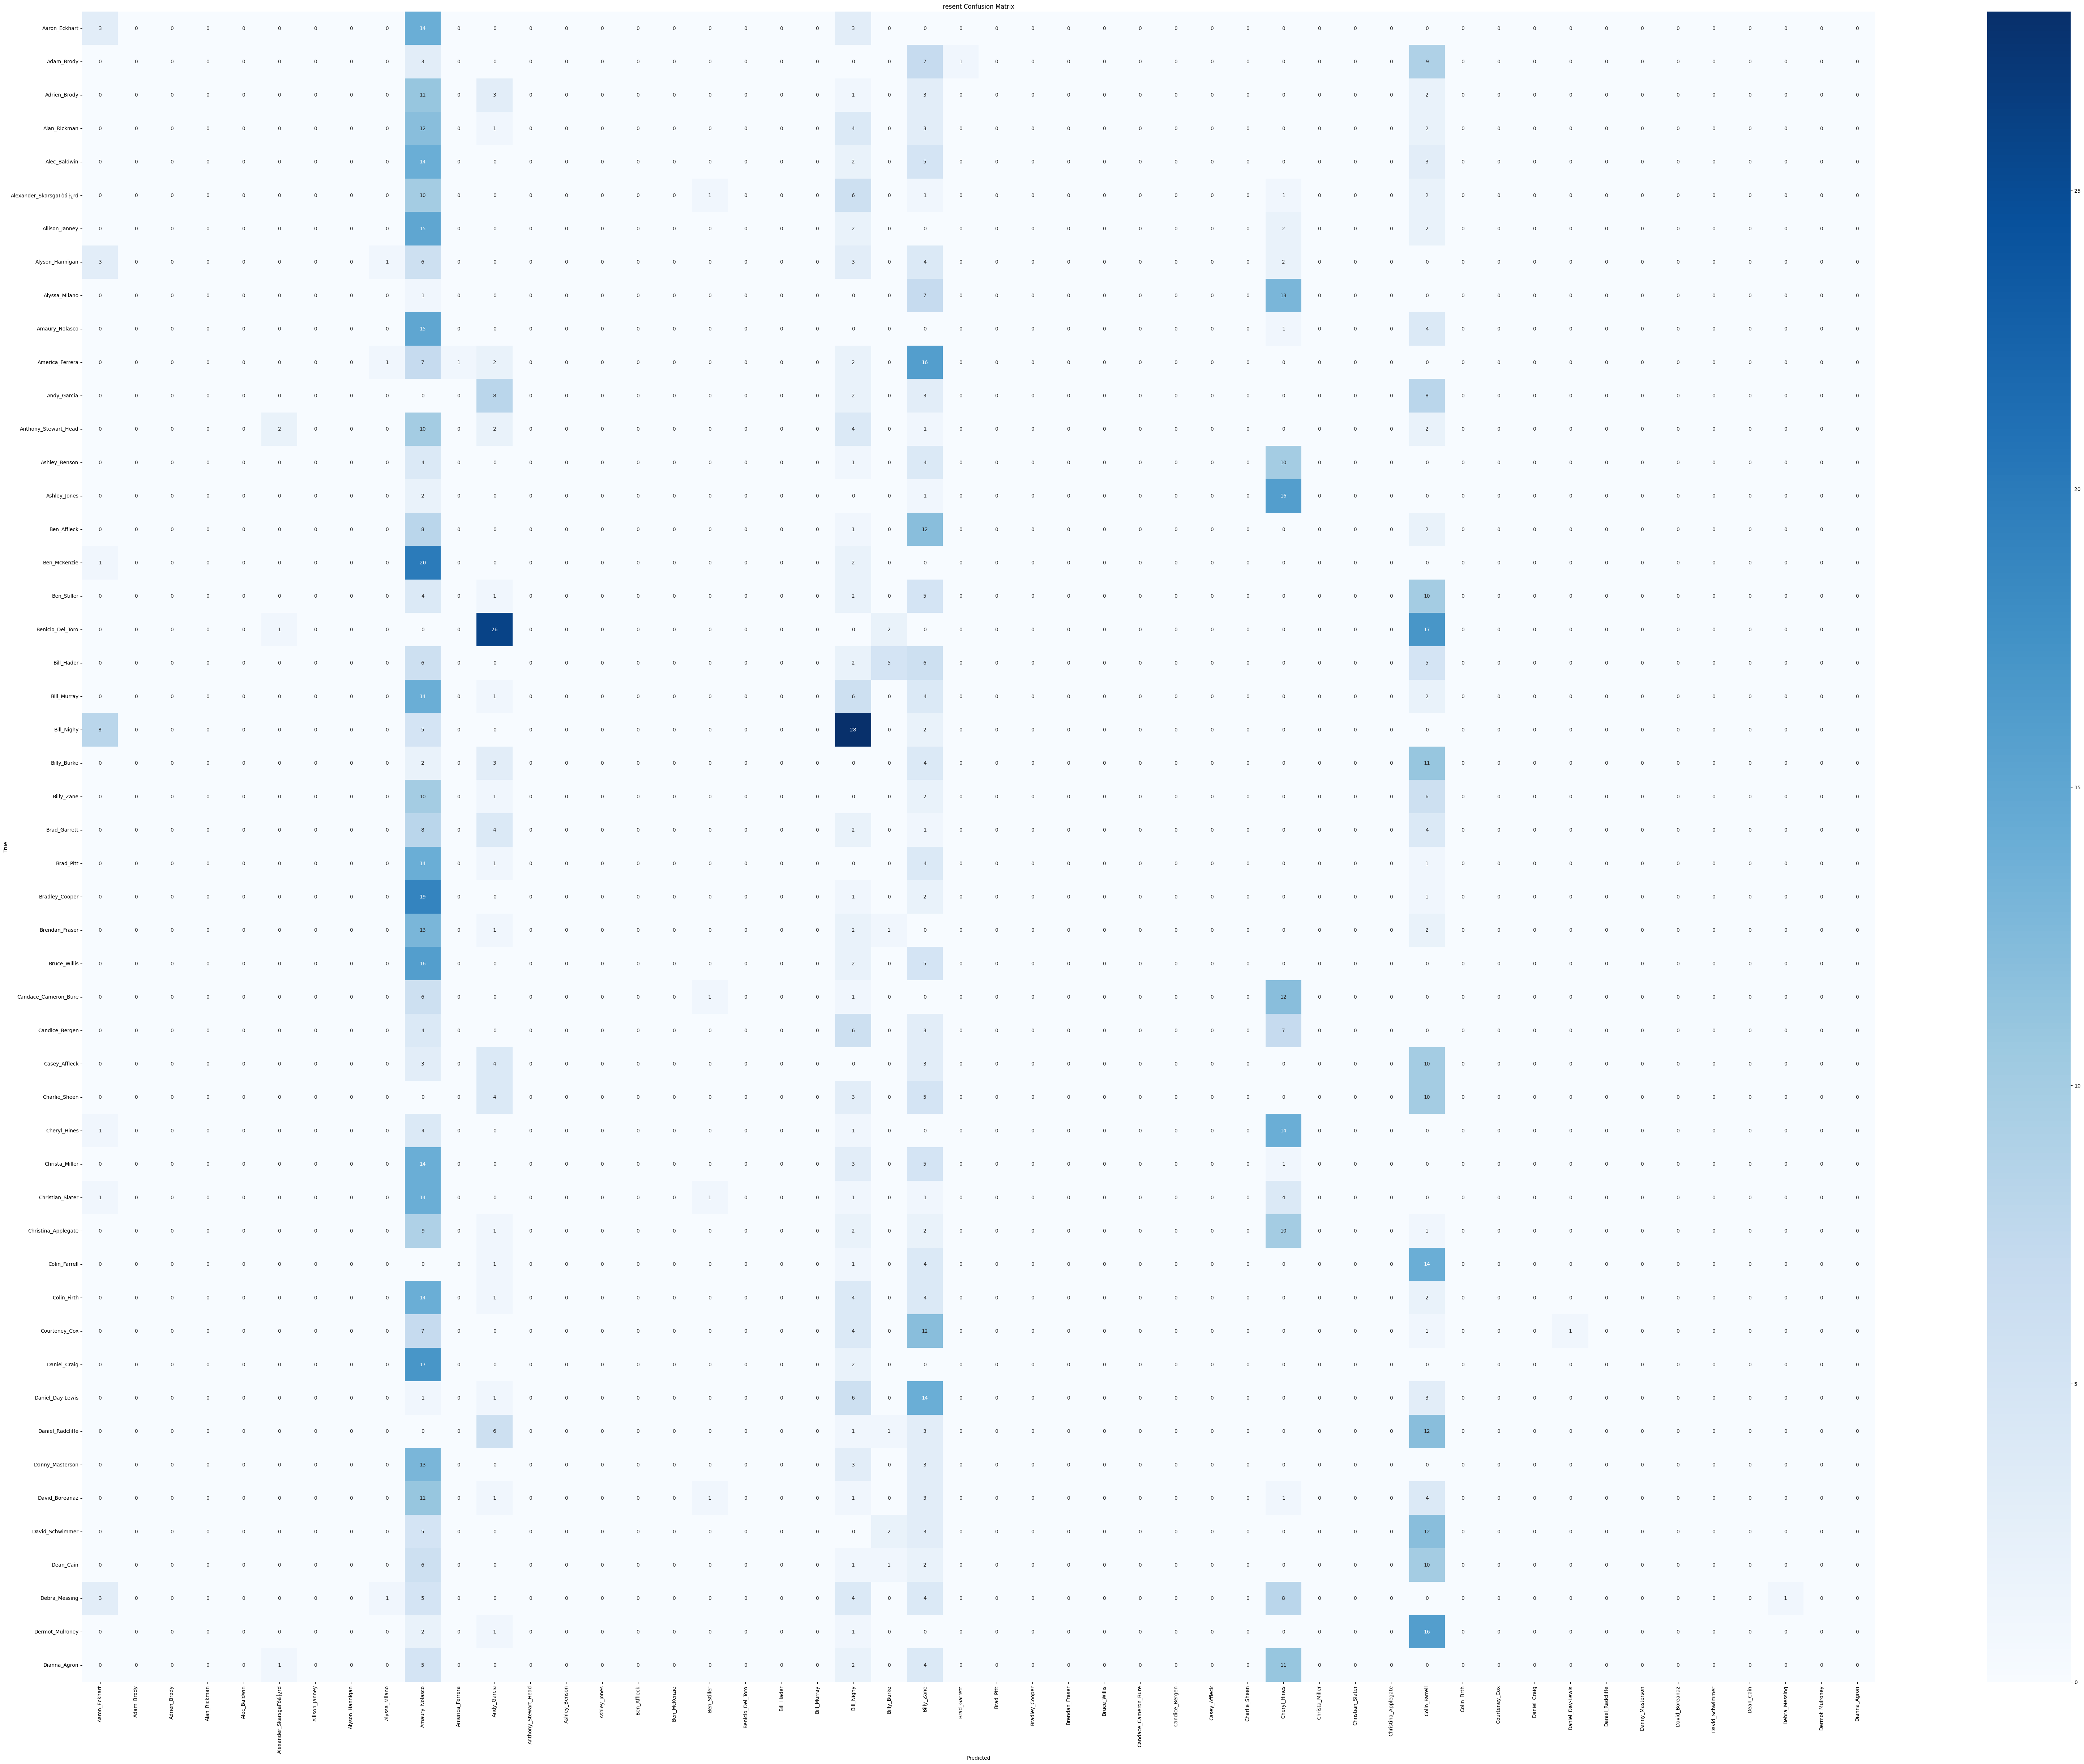

In [ ]:
import seaborn as sns
resent_cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(80, 60))
sns.heatmap(resent_cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator_resnet.class_indices.keys(), yticklabels=val_generator_resnet.class_indices.keys())
plt.title("resent Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

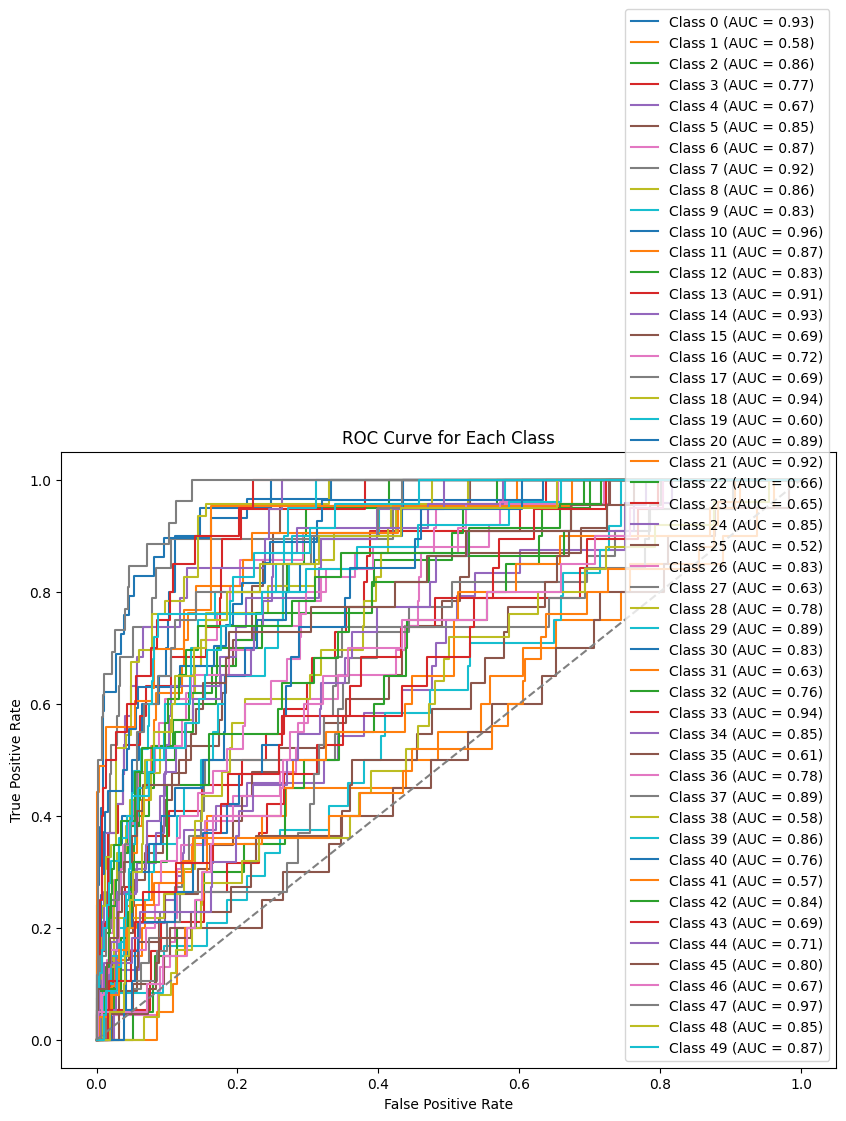

In [ ]:
from sklearn.preprocessing import label_binarize

n_classes = all_labels.shape[1]  # number of classes
y_true_bin = label_binarize(y_true_classes, classes=np.arange(n_classes))
y_pred_bin = y_pred  # The raw prediction probabilities

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)

    # Plotting each class ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot random classifier (diagonal)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')

# Show the plot
plt.show()

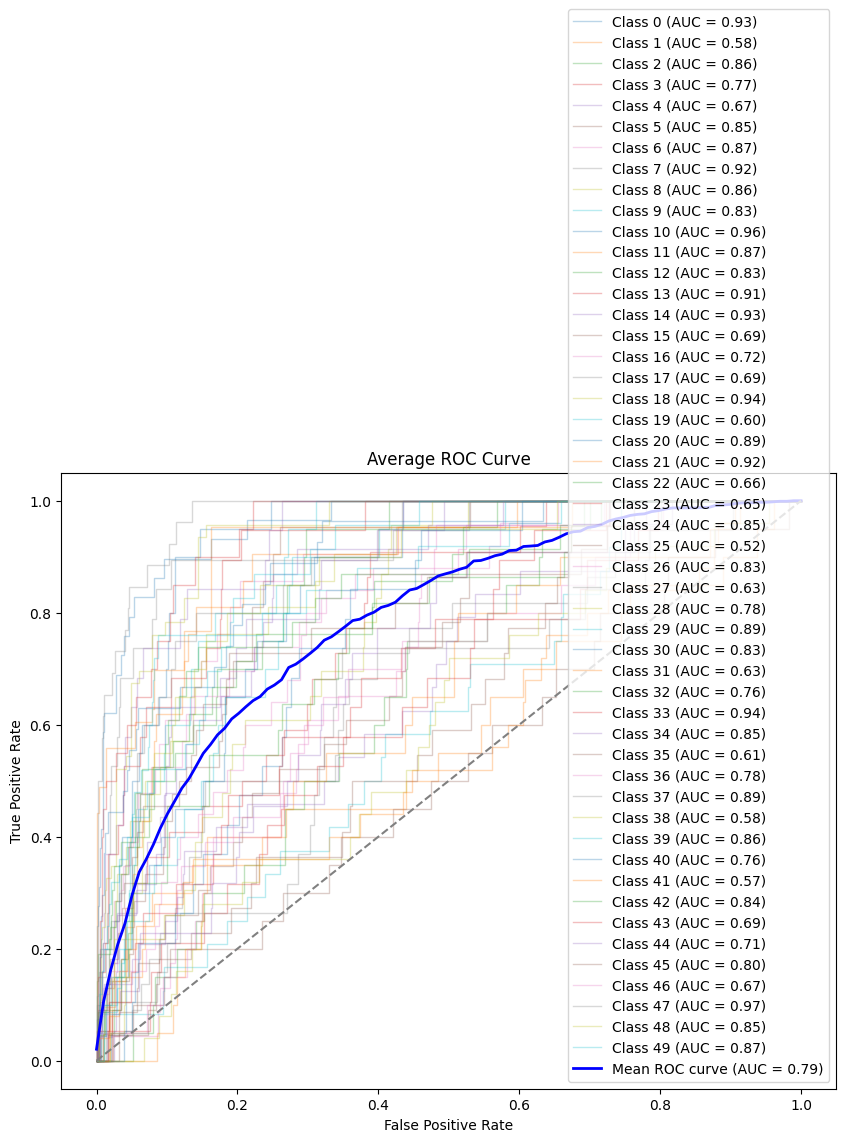

In [ ]:
n_classes = all_labels.shape[1]  # number of classes
y_true_bin = label_binarize(y_true_classes, classes=np.arange(n_classes))
y_pred_bin = y_pred  # The raw prediction probabilities

fpr_all = []
tpr_all = []
roc_auc_all = []

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    roc_auc_all.append(roc_auc)
    # Calculate the mean ROC curve
# First, interpolate the TPR at common FPR points
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(mean_fpr, fpr_all[i], tpr_all[i])

mean_tpr /= n_classes

# Calculate the AUC for the average ROC curve
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plotting the ROC curves for each class and the average curve
plt.figure(figsize=(10, 8))

# Plot the individual class ROC curves
for i in range(n_classes):
    plt.plot(fpr_all[i], tpr_all[i], lw=1, alpha=0.3, label=f'Class {i} (AUC = {roc_auc_all[i]:.2f})')

# Plot the average ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (AUC = {mean_roc_auc:.2f})', lw=2)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc='lower right')
# Show the plot
plt.show()